# Projet 7 : Implémentez un modèle de scoring
*Philippe LONJON (janvier 2020)*

---
Ce projet consiste à développer un modèle de scoring, qui donnera une prédiction sur la probabilité de faillite d'un client qui demande un prêt.
Il s'agit d'un problème :
* **Supervisé** : Les étiquettes (Défauts de crédit) sont connus
* **Classification** : Les valeurs à prédire sont des variables qualitatives
---
## Notebook 3 : Sélection de features via un modèle de gradient boosting
Le notebook comprend :
- Une sélection des features selon leur importance dans un modèle de gradient boosting

Les données à utiliser sont issues du notebook précédent, et se trouvent dans le répertoire : `data/features`

In [1]:
import numpy as np
import pandas as pd

# Librairies machine learning
from sklearn.model_selection import train_test_split
import lightgbm as lgbm

# Module des fonctions du notebook
import fonctions08 as f

# Divers
from time import time, strftime, gmtime
import gc

# Heure démarrage
t0=time()

# Autoreload pour prise en compte des changments dans le module fonctions
%load_ext autoreload
%autoreload 1
%aimport fonctions08

In [2]:
# Constantes
random_state = 1
nb_iteration_feature_importances = 3
nrows = None

# 1. Chargement et préparation données pour modélisation
On prépare les donnes pour la modélisation, on n'utilise que les données d'entrainement.

In [3]:
# Chargement dataframe
train_features = f.import_csv("data/features/train_features.csv", nrows=nrows)
train_target = f.import_csv("data/features/train_target.csv", nrows=nrows)

Memory usage of dataframe is 1313.82 MB
Memory usage after optimization is: 351.04 MB
Decreased by 73.3%
Memory usage of dataframe is 3.28 MB
Memory usage after optimization is: 1.03 MB
Decreased by 68.7%


In [4]:
# Jointure dataframes features et étiquettes
df = train_features.merge(train_target, on='SK_ID_CURR', how='left')

# Identifiant colonne en index
df = df.set_index(['SK_ID_CURR'])

# Dataset features et etiquettes
train_features = df.drop(columns='TARGET', axis=1)
train_target = df[['TARGET']]

print(train_features.shape)
print(train_target.shape)

(215257, 799)
(215257, 1)


In [5]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

# Suppression des variables pour libérer de la mémoire
gc.enable()
del df
gc.collect()

# Mémoire après suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=28522233856, percent=16.9, used=5800640512, free=28522233856)
Mémoire utilisée : 851 Mb
svmem(total=34322874368, available=28890411008, percent=15.8, used=5432463360, free=28890411008)
Mémoire utilisée : 500 Mb


# 2. Importances des features avec modèle LGBM
Les classes des étiquettes sont déséquilibrées, on sous-échantillons la classe sur-représenté pour arriver à des échantillons de même taille pour chaque classe.

In [6]:
# Echantillons avec classes équilibrées
train_target_0 = train_target[train_target['TARGET'] == 0]
train_target_1 = train_target[train_target['TARGET'] == 1]

train_target_0_sample = train_target_0.sample(len(train_target_1),
                                        random_state=random_state)

# Target balanced
target_sample_balanced = pd.concat([train_target_0_sample, train_target_1], axis=0)

# Features balanced
features_sample_balanced = train_features\
    .loc[target_sample_balanced.index, :]\
    .iloc[:, :nrows]

#### Recherche de l'hyperparamètre n_estimators à utiliser
On va utiliser prend ici le modèle par défaut de gradient boosting. On définit comme n_estimators, le nombre de boosting à partir duquel la métrique d'évaluation n'évolue plus.

In [7]:
# Creation d'un train set et d'un test set
X_train, X_test, y_train, y_test =\
    train_test_split(features_sample_balanced, target_sample_balanced,
                     test_size=0.3,
                     stratify=target_sample_balanced, 
                     random_state=1)

# Creation des dataset pour lgb
train_set = lgbm.Dataset(data=X_train, label=y_train)
test_set = lgbm.Dataset(data=X_test, label=y_test)

# Model et parametres par defaut
model = lgbm.LGBMModel(objective='binary', metric='auc', boosting_type= 'gbdt')
default_params = model.get_params()

# Suppression de n_estimators, qui sera paramétré dans la méthode cv
del default_params['n_estimators']

cv_results = lgbm.cv(default_params, train_set, num_boost_round=10000,
                   early_stopping_rounds=100, metrics='auc', nfold=5, seed=1)

print(f"Le meilleur score de validation est {cv_results['auc-mean'][-1]:.5f}"
      f" avec un écart type de {cv_results['auc-stdv'][-1]:.5f}")

print(f"Le nombre de boosting optimal est {len(cv_results['auc-mean'])}")

# Nombre optimal d'estimateurs avec cv
n_estimators_selected = len(cv_results['auc-mean'])

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Le meilleur score de validation est 0.77421 avec un écart type de 0.00609
Le nombre de boosting optimal est 123


Une fois n_estimators trouvé, on peut définir les paramètres du modèle que l'on va utiliser.

In [8]:
# Vecteur pour enregistrer l'importance des features
feature_importances = np.zeros(train_features.shape[1])

# Modele lgbm
parameters = {
    'objective': 'binary', # classification binaire
    'metric':'auc',
    'boosting_type': 'gbdt', # Gradient boosting
    'n-estimators': n_estimators_selected
}

On calcul plusieurs fois l'importance des variables.

In [9]:
# Heure démarrage
ta=time()

for i in range(nb_iteration_feature_importances):
    # Creation d'un jeu d'entrainement et de test
    X_train, X_test , y_train, y_test = \
        train_test_split(features_sample_balanced,
                         target_sample_balanced,
                         test_size=0.3,
                         stratify=target_sample_balanced,
                         random_state=i)
    
    X_train = np.array(X_train)
    y_train = np.ravel(y_train)
    X_test = np.array(X_test)
    y_test = np.ravel(y_test)
    
    model = lgbm.LGBMModel(**parameters)
    
    clg_lgbm = model.fit(X_train, y_train, eval_metric=['auc'],
                         eval_set=[(X_test, y_test), (X_train, y_train)],
                         eval_names=['valid', 'train'],
                         categorical_feature='auto',
                         early_stopping_rounds=100, verbose=200)
    
    feature_importances += model.feature_importances_

tb = time()
print("computing time : {:8.6f} sec".format(tb-ta))
print("computing time : " + strftime('%H:%M:%S', gmtime(tb-ta)))

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.896213	valid's auc: 0.773897
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.897831	valid's auc: 0.775391
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.895949	valid's auc: 0.781362
computing time : 21.334788 sec
computing time : 00:00:21


Puis on fait la moyenne des résultats obtenus.

In [10]:
# Moyenne des features importances
feature_importances = feature_importances / nb_iteration_feature_importances

feature_importance_df = pd.DataFrame({
    'feature': list(train_features.columns),
    'importance': feature_importances
    })\
    .sort_values('importance', ascending=False)

print(feature_importance_df.head())

                           feature  importance
74      application_EXT_SOURCE_ALL   77.333333
70        application_AMT_DURATION   69.333333
6        application_DAYS_EMPLOYED   62.000000
73  application_GOODS_CREDIT_RATIO   55.333333
25        application_EXT_SOURCE_1   53.000000


In [11]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

# Suppression des variables pour libérer de la mémoire
gc.enable()
del train_target_0, train_target_1, train_target_0_sample
del features_sample_balanced, target_sample_balanced
del X_train, X_test , y_train, y_test
gc.collect()

# Mémoire après suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=28501917696, percent=17.0, used=5820956672, free=28501917696)
Mémoire utilisée : 821 Mb
svmem(total=34322874368, available=28789235712, percent=16.1, used=5533638656, free=28789235712)
Mémoire utilisée : 548 Mb


# 3. Sélection des features
On trie les variables par ordre d'importance, puis on garde celles qui contrinue à 95% au modèle.

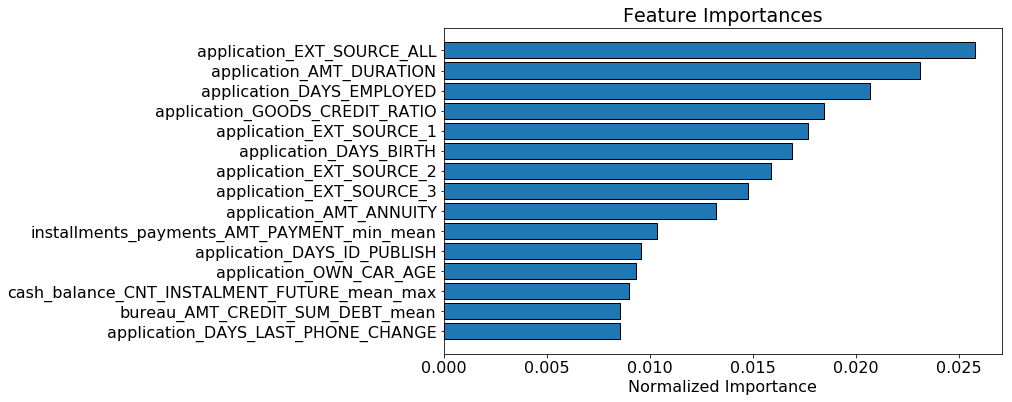

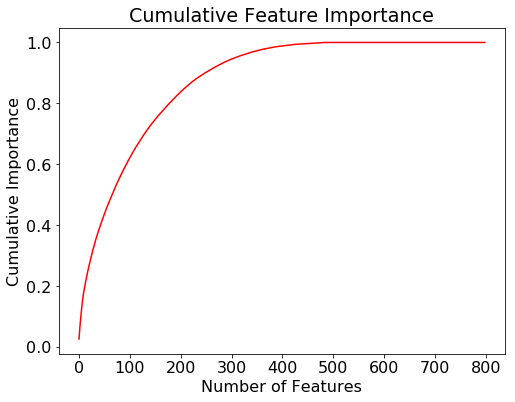

307 features required for 0.95 of cumulative importance


In [12]:
# Affichage des features les plus importantes et de l'importance cumulée par feature
norm_feature_importances = f.plot_feature_importances(feature_importance_df, threshold = 0.95)

On sélectionne les features les plus importantes sur les jeux d'entrainement et de test.

In [13]:
# Seuil d'importance cumulée des variables 
threshold = 0.95

# Sélection des variables importantes
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Nouveau jeu d'entrainement
train_features_selected = train_features[features_to_keep]
print(f"Nouveau jeu d'entrainement avec {train_features_selected.shape[1]} features.")

#Nouveau jeu de test
test_features = f.import_csv("data/features/test_features.csv", nrows=nrows)
test_features = test_features.set_index(['SK_ID_CURR'])
test_features_selected = test_features[features_to_keep]

# Alignement des colonnes de du jeu de test sur celui du train avant sauvegarde
train_features_selected, test_features_selected = \
    train_features_selected.align(test_features_selected, join='left', axis=1)

# Sauvegarde du nouveau dataset
train_features_selected.to_csv("data/features/train_features_selected.csv")
test_features_selected.to_csv("data/features/test_features_selected.csv")

Nouveau jeu d'entrainement avec 307 features.
Memory usage of dataframe is 563.07 MB
Memory usage after optimization is: 147.98 MB
Decreased by 73.7%


In [14]:
# Mémoire avant suppression
print(f"Mémoire utilisée : {f.memory_usage():.0f} Mb")

svmem(total=34322874368, available=28352446464, percent=17.4, used=5970427904, free=28352446464)
Mémoire utilisée : 942 Mb


In [15]:
t1 = time()
print("computing time : {:8.6f} sec".format(t1-t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1-t0)))

computing time : 470.703823 sec
computing time : 00:07:50
